# HFUL Estimator and Single Instrument IV exercise

In [116]:
import statistics as stats
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.stats import distributions as iid
import pandas as pd


## Data generation processes

We now perform a monte-carlo analysis to compare the results of our estimators. 

In [91]:
def draw_b_ols(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from selected DGP.
    """
    y,X,Z =  dgp(N)
    
    return np.linalg.solve(X.T@X,X.T@y) # Solve normal eqs

In [92]:
def draw_b_iv(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from selected DGP.
    """
    y,X,Z =  dgp(N)

    return np.linalg.solve(Z.T@X,Z.T@y) # Solve normal eqs

In [93]:
def draw_b_hful(N,dgp):
    """
    Generate a random variate $b$ from a sample of $N$ draws from selected DGP.
    """
    XXinv,Xy =  dgp(N)
    print(XXinv)
    print(Xy)

    return la.inv(XXinv) @ Xy # Solve normal eqs

### Single instrument dgp

In [94]:
iterations = 1000 # number of simulations
N = 100 # number of obs - want to test finite samples
beta = 1 # true beta value
pi = 0.8 # how strong is the instrument?
gamma = 0.5 # effect of unobserved variable on X
beta_endo = 1


def single_dgp(N,beta,gamma,pi,sigma_u,sigma_v):
    u = iid.norm(scale=sigma_u).rvs(N)
    v = iid.norm(scale=sigma_v).rvs(N)
    Z = iid.norm().rvs(N)
    w = iid.norm().rvs(N) # unobserved 'omitted variable'
    

    X = Z*pi + gamma*w + v # define X
    y = X*beta + w + np.multiply(X, u) # define y; X is correlated with u & heteroskedasticity
   
    df = pd.DataFrame({'y':y,'x':X,'z':Z,'Constant':1})

    return df[['y']],df[['Constant','x']],df[['Constant','z']]

### HFUL dgp

In [108]:
def hful(y, X, Z):
    """HFUL estimator"""
    P = Z @ la.inv(Z.T @ Z) @ Z.T
    # Extract the diagonal of P, make it a diagonal matrix
    P_diag = np.diag(P.diagonal())
    Xbar = np.column_stack((y, X))
    
    # construct the components of the A matrix
    barXXinv = la.inv(Xbar.T @ Xbar)
    barXPX = Xbar.T @ P @ Xbar
    barXdiagPX = Xbar.T @ P_diag @ Xbar
    
    # calculate the A matrix and take its smallest eigenvalue; calculate alphahat
    alphatilde = min(np.linalg.eig(barXXinv @ (barXPX - barXdiagPX))[0])
    alphahat = (alphatilde - (1-alphatilde)/n) / (1 - (1-alphatilde)/n)
    
    # construct the components of betaHat
    XXinv = X.T @ P @ X - X.T @ P_diag @ X - alphahat * X.T @ X
    Xy = X.T @ P @ y - X.T @ P_diag @ y - alphahat * X.T @ y
    
    return la.inv(XXinv) @ Xy

list_beta = []

for i in range(iterations):
    u = iid.norm().rvs(N)
    v = iid.norm().rvs(N)
    Z = iid.norm().rvs(N) # Z independent, for now one variable
    w = iid.norm().rvs(N) # unobserved 'omitted variable'
    
    constant = np.ones(N) # to add to X and Z
    
    X = Z*pi + gamma*w + v # define X
    Xmat = np.column_stack((constant,X)) # make matrix
    y = X*beta + w + np.multiply(X, u) # define y; X is correlated with u & heteroskedasticity
    Zmat = np.column_stack((constant,Z)) # make Z matrix

    # calculate estimates
    res = hful(y,Xmat,Zmat)
    list_beta.append(res)
    b_HFUL = pd.DataFrame(list_beta).iloc[:,1]

## Plotting - Estimators with one instrument

Define plotting function

In [96]:
def graph_hist(data, caption):
    """Plot a histogram of the relevant data"""
    plt.hist(data, bins='auto')
    plt.title(caption)
    plt.axvline(stats.mean(data), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(beta_endo, color='r', linestyle='dashed', linewidth=1)
    plt.show()
    print("Estimate:", stats.mean(data))

## IV Single Instrument

In [118]:
B = pd.DataFrame([draw_b_iv(N,lambda N: single_dgp(N,1,0,.01,1,1))[1] for i in range(iterations)]).values.tolist()
beta_iv_single = [val for sublist in B for val in sublist]

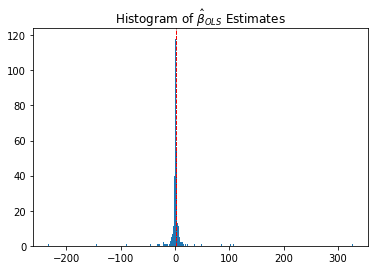

Estimate: 1.273274813576752


In [98]:
graph_hist(beta_iv_single, r"Histogram of $\hat{\beta}_{OLS}$ Estimates")

## OLS

In [99]:
B = pd.DataFrame([draw_b_ols(N,lambda N: single_dgp(N,1,0,.01,1,1))[1] for i in range(iterations)]).values.tolist()
beta_OLS = [val for sublist in B for val in sublist]

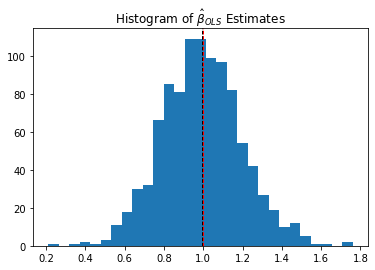

Estimate: 0.9921495282559117


In [100]:
graph_hist(beta_OLS, r"Histogram of $\hat{\beta}_{OLS}$ Estimates")

## HFUL

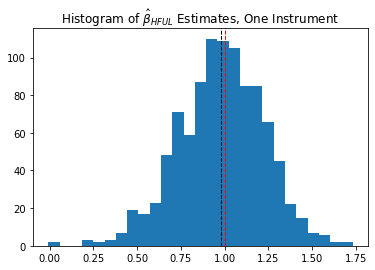

Estimate: 0.9805454513668562


In [115]:
graph_hist(b_HFUL, r"Histogram of $\hat{\beta}_{HFUL}$ Estimates, One Instrument")
